<a href="https://colab.research.google.com/github/GermanOmar/Melting/blob/master/Eff_WAAM_10_07_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melting efficiency evaluation in wire arc additive manufacturing: A machine learning approach

<a href="https://ibb.co/5Rvr5t7"><img src="https://i.ibb.co/kS04hkd/Fig1-4.png" WIDTH="500" HEIGHT="300"  border="0"></a>

 Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

Randomized search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

 Upload database:

In [ ]:
!git clone https://github.com/GermanOmar/Melting

Cloning into 'Melting'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 31 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), done.


In [ ]:
#Experimental data
data = pd.read_table('DSCMT.txt') 
data.describe()


,WD,WFS,TS,P,W,H,AW,ME
count,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000
mean,0.954667,95.451333,8.326533,1819.171733,5.576933,2.412533,12.319200,0.445646
std,0.172653,53.012550,5.220140,757.431591,1.332001,0.535108,5.373648,0.055174
min,0.800000,28.000000,1.660000,531.220000,2.520000,1.610000,4.450000,0.306563
25%,0.800000,54.585000,4.450000,1171.550000,4.605000,1.970000,7.565000,0.411206
50%,0.800000,80.330000,6.670000,1798.200000,5.510000,2.360000,11.360000,0.444696
75%,1.200000,123.250000,10.980000,2435.315000,6.415000,2.830000,16.960000,0.491687
max,1.200000,222.500000,25.000000,3266.550000,8.830000,3.620000,22.890000,0.552825



Setting inputs - output:

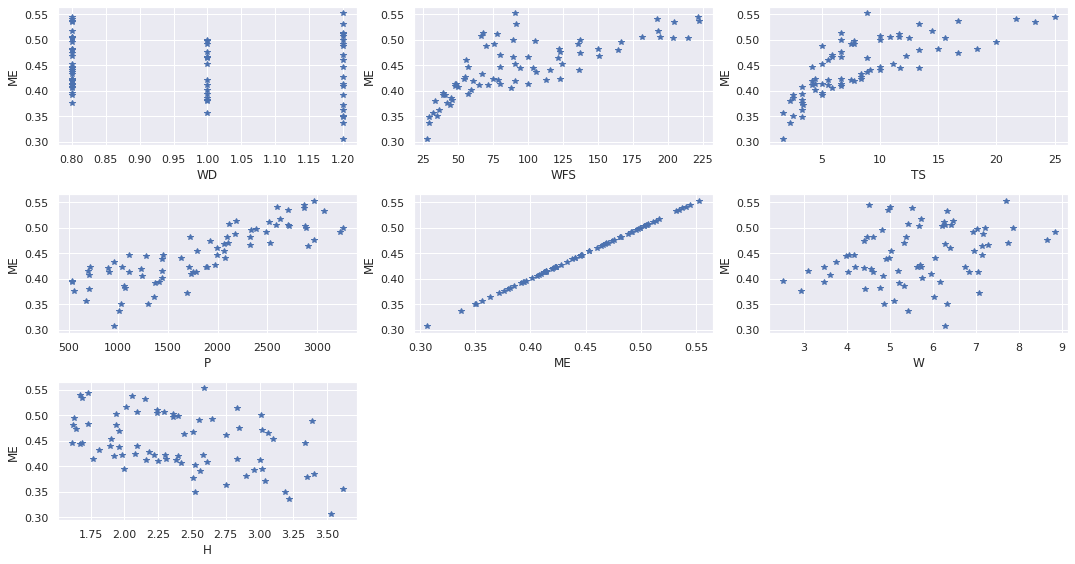

In [ ]:
fields = ['WD', 'WFS','TS','P', 'ME', 'W', 'H']
import seaborn as sns
sns.set()

fig = plt.figure()
fig.set_size_inches((15,8))
for i, field in enumerate(fields):
  plt.subplot(3, 3, i + 1)
  plt.plot(data[field], data['ME'], 'b*')
  plt.xlabel(field)
  plt.ylabel('ME')

plt.tight_layout()

X=data[['WD', 'WFS','TS','P']]
Y=data['ME'][:,None]

#fig.tight_layout()

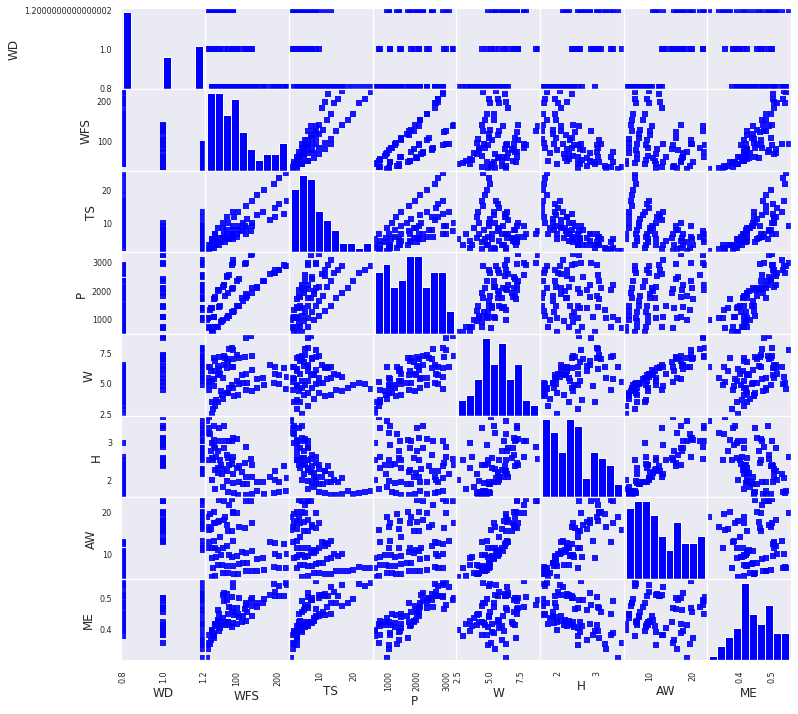

In [ ]:
from pandas.plotting import scatter_matrix
#DISPLAY MATRIX - identificar correlacion entre variables
import seaborn as sns
sns.set()

plt.rcParams["axes.grid"] = False

#pd.tools.plotting.scatter_matrix(df, alpha=0.2, c='red', hist_kwds={'color':['burlywood']})

#scatter_matrix(data, alpha=0.2, marker='o', figsize = (12,12), color = 'blue')
scatter_matrix(data, alpha=0.9,marker='s', figsize = (12,12),  c='blue', hist_kwds={'color':['blue']})

warnings.filterwarnings("ignore")

# Melting efficiency prediction

 Split data

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1234)
print('training samples:', X_train.shape[0],  ' test samples:', X_test.shape[0])

training samples: 60  test samples: 15


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#y_train = scaler.fit_transform(y_train)
#y_test = scaler.transform(y_test)


#Results:

# GPs

Gaussian Process
MSE train: 0.0002609268587602704
MSE test: 0.00021280320689394912
MSE train < MSE test? False

R2_train:  0.9156843038173992
R2_test:  0.919209146123589

R2:  0.919209146123589
RMSE:  0.014587775940627452
MAE:  0.011269638024058363
IM:  0.08286718299886182



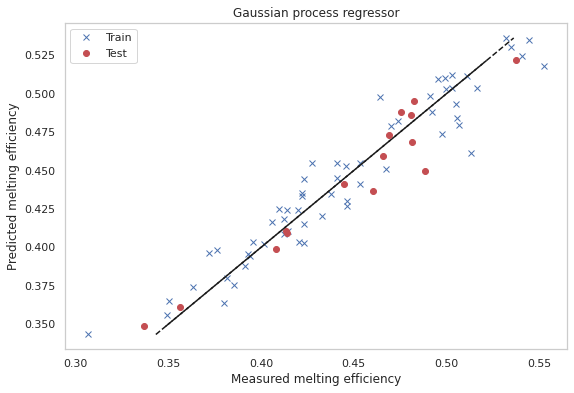

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
 
GP=GPR(alpha=0.001, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=40, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=1234)
 
#Training
GP.fit(X_train,y_train)
 
#Testing
y_star_train = GP.predict(X_train)
y_pred = GP.predict(X_test)
 
#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'bx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y_pred, 'ro', label = 'Test')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.legend()
plt.ylabel('Predicted melting efficiency')
plt.xlabel('Measured melting efficiency')
plt.title("Gaussian process regressor")
 
from sklearn.metrics import mean_squared_error
MSE_test = mean_squared_error(y_test, y_pred)
MSE_train = mean_squared_error(y_train, y_star_train)
 
print("Gaussian Process")
print('MSE train:', MSE_train)
print('MSE test:', MSE_test)
print("MSE train < MSE test?", MSE_train < MSE_test)
print()
from sklearn.metrics import r2_score
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)
R2_test=r2_score(y_test, y_pred)
print('R2_test: ',R2_test)
print()
""" 
RE=100 * abs(y_test - y_pred) / y_test
print('Relative error (%): ',RE)
"""
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

In [ ]:
# initialize model and define the space of the hyperparameters to
# perform the grid-search over
model = GP
n_restarts_optimizer = [5, 10, 20, 40]
alpha = [0.001, 0.01, 0.1, 1]


grid = dict(n_restarts_optimizer=n_restarts_optimizer, alpha=alpha )

In [ ]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1234)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="neg_mean_squared_error")
searchResults = randomSearch.fit(X_train, y_train)
# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_
print("R2: {:.2f}".format(bestModel.score(X_test, y_test)))
print(bestModel)

[INFO] grid searching over the hyperparameters...
[INFO] evaluating...
R2: 0.90
GaussianProcessRegressor(alpha=0.001, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=40, normalize_y=True,
                         optimizer='fmin_l_bfgs_b', random_state=1234)


# XGB

In [ ]:
import pickle
import xgboost as xgb

xgbr = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1234,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [ ]:
score = xgbr.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.9998973705861264


-XGBRegressor -
------------------
MSE test: 0.0003673861428122284

R2:  0.86052164996295
RMSE:  0.019167319656442014
MAE:  0.015794707377551287
IM:  0.14167240046322555



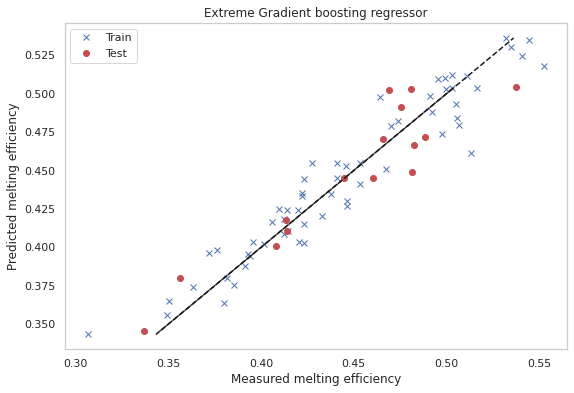

In [ ]:
print("-XGBRegressor -")
print("------------------")

#EVAL
from sklearn.metrics import mean_squared_error as MSE
MSE_test = MSE(y_test, y_pred)

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'bx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y_pred, 'ro', label = 'Test')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.legend()
plt.ylabel('Predicted melting efficiency')
plt.xlabel('Measured melting efficiency')
plt.title("Extreme Gradient boosting regressor")

print('MSE test:', MSE_test)

print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

In [ ]:
# initialize model and define the space of the hyperparameters to
# perform the grid-search over
model = xgbr
n_estimators = [10, 100, 1000, 10000]
learning_rate = [0.1, 0.01, 1e-3]
max_depth = [5, 10, 20, 40]
reg_lambda = [0.01, 0.1, 1]


grid = dict(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth )

In [ ]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="neg_mean_squared_error")
searchResults = randomSearch.fit(X_train, y_train)
# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_
print("R2: {:.2f}".format(bestModel.score(X_test, y_test)))
print(bestModel)

[INFO] grid searching over the hyperparameters...
[INFO] evaluating...
R2: 0.87
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=1234,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)


In [ ]:
# get importance

importance = xgbr.feature_importances_
# summarize feature importance

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance


Feature: 0, Score: 0.04650
Feature: 1, Score: 0.08824
Feature: 2, Score: 0.10469
Feature: 3, Score: 0.76057


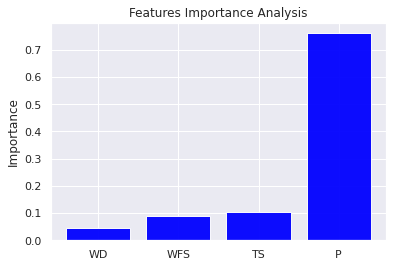

In [ ]:
# Create lists for the plot
import seaborn as sns
sns.set()

#plt.rcParams["axes.grid"] = False

labels = ['WD', 'WFS', 'TS', 'P']
x_pos = np.arange(len(labels))


fig, ax = plt.subplots()
#fig.set_size_inches((8,5))

ax.bar(x_pos, importance, align='center', alpha=0.95, color='blue')
ax.set_ylabel('Importance')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Features Importance Analysis')
ax.yaxis.grid(True)


#MLP


R2_train:  0.9156843038173992
R2:  0.9110554759345563
RMSE:  0.019167319656442014
MAE:  0.011427414672555447
IM:  0.09170114672205067



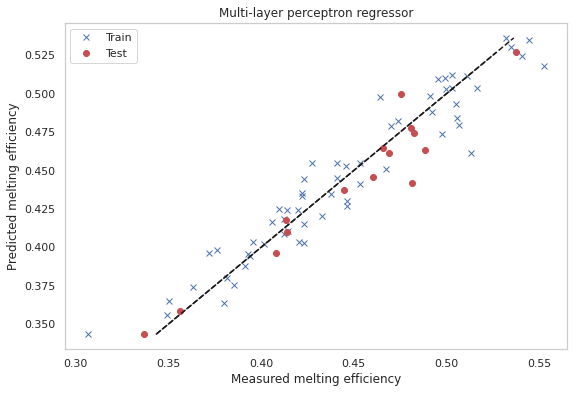

In [ ]:
from sklearn.neural_network import MLPRegressor

MLP =MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=5, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1234, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
#MLP = MLPRegressor(hidden_layer_sizes=(1000,1000,1000), activation='relu', solver='adam', max_iter=800)

#START TRAINING
MLP.fit(X_train,y_train)
#PREDICTION
y_pred=MLP.predict(X_test)

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'bx', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y_pred, 'ro', label = 'Test')
plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.legend()
plt.ylabel('Predicted melting efficiency')
plt.xlabel('Measured melting efficiency')
plt.title("Multi-layer perceptron regressor")
print()

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE 
R2_train=r2_score(y_train, y_star_train)
print('R2_train: ',R2_train)

#METRICS: R2, RMSE, MAE
R2=r2_score(y_test, y_pred)
print('R2: ',R2)
RMSE = np.sqrt(MSE_test)
print("RMSE: ", RMSE)
MAE = MAE(y_test, y_pred)
print("MAE: ", MAE)
IM=np.sqrt(((1-R2)**2) + (RMSE**2) + (MAE**2) )
print("IM: ", IM)
print()

In [ ]:
# initialize model and define the space of the hyperparameters to
# perform the grid-search over
model = MLP
hidden_layer_sizes = [5, 8, 10]
activation = ['relu','tanh']
solver = ["lbfgs", "sgd", "adam"]

grid = dict(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver )

In [ ]:
# initialize a cross-validation fold and perform a randomized-search
# to tune the hyperparameters
print("[INFO] grid searching over the hyperparameters...")
cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1234)
randomSearch = RandomizedSearchCV(estimator=model, n_jobs=-1,
	cv=cvFold, param_distributions=grid,
	scoring="neg_mean_squared_error")
searchResults = randomSearch.fit(X_train, y_train)
# extract the best model and evaluate it
print("[INFO] evaluating...")
bestModel = searchResults.best_estimator_
print("R2: {:.2f}".format(bestModel.score(X_test, y_test)))
print(bestModel)

[INFO] grid searching over the hyperparameters...
[INFO] evaluating...
R2: 0.89
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=5, learning_rate='adaptive',
             learning_rate_init=0.001, max_fun=15000, max_iter=3000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1234, shuffle=True, solver='lbfgs',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)


## Comparisson

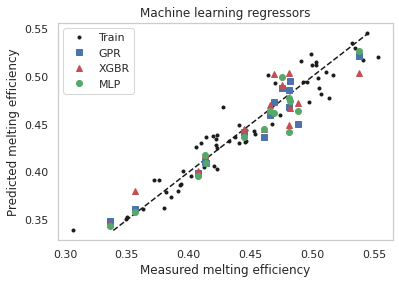

In [ ]:
import seaborn as sns
sns.set()

y1=GP.predict(X_test)
y2=xgbr.predict(X_test)
y3=MLP.predict(X_test)

#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
#fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(y_train, y_star_train, 'k.', label = 'Train')
plt.plot([y_star_train.min(), y_star_train.max()], [y_star_train.min(), y_star_train.max()], 'k--')
plt.plot(y_test, y1, 'bs', label = 'GPR')
plt.plot(y_test, y2, 'r^', label = 'XGBR')
plt.plot(y_test, y3, 'go', label = 'MLP')

plt.legend()
plt.ylabel('Predicted melting efficiency')
plt.xlabel('Measured melting efficiency')
plt.title("Machine learning regressors")
print()

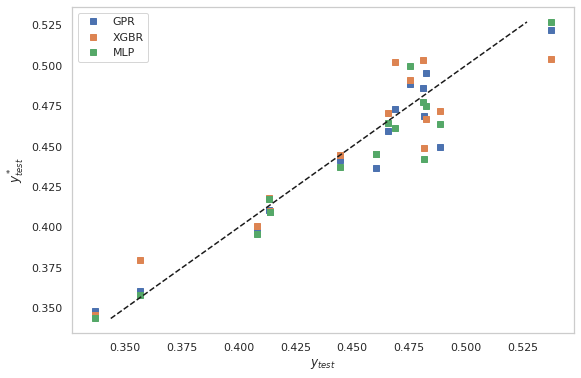

In [ ]:
models = [ GP, xgbr, MLP]
labels = ['GPR', 'XGBR', 'MLP']

fig = plt.figure()
fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_test)
  plt.plot(y_test, y_pred, 's' ,label = label)

plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--')
plt.ylabel('$y^*_{test}$')
plt.xlabel('$y_{test}$')
plt.legend()  
  

CROSS-VALIDATION

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error 
from sklearn.model_selection import cross_val_score as CV

import warnings
warnings.filterwarnings('ignore')

models = [ xgbr,  GP, MLP, ]
labels = ['XGBR', 'GPs', 'MLP', '']
IMS = []

print("--------------------------------------------------------------")
print("%5s | %5s | %5s | %5s | %5s " % ("ML algorithm",  "CV-R2", "CV-MSE", "CV-MAE", "IM"))
print("--------------------------------------------------------------")

for mod, label in zip( models, labels): 
  y_star_train = mod.predict(X_train)
 
  scoreR2 = CV(mod, X_train, y_train, cv=5, scoring='r2')
  #print(-1*scoreR2)
  scoreMSE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
  #print(-1*scoreMSE)
  scoreMAE = CV(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
  #print(-1*scoreMAE)
  IM=np.sqrt(((1-scoreR2)**2) + (scoreMSE) + (scoreMAE**2) )
  #print("IM: ", IM)
  
 
  print("%15s | %.4f | %.4f | %.4f | %.4f " % (label,  scoreR2.mean(), -1*scoreMSE.mean(), -1*scoreMAE.mean() , np.sqrt(((1-scoreR2.mean())**2) + (-1*scoreMSE.mean()) + (scoreMAE.mean()**2) )))
print("--------------------------------------------------------------")

--------------------------------------------------------------
ML algorithm | CV-R2 | CV-MSE | CV-MAE |    IM 
--------------------------------------------------------------
           XGBR | 0.8461 | 0.0005 | 0.0154 | 0.1562 
            GPs | 0.8678 | 0.0004 | 0.0153 | 0.1345 
            MLP | 0.8403 | 0.0005 | 0.0165 | 0.1620 
--------------------------------------------------------------


Results:

In [ ]:
R_GP=np.array(GP.predict(X_test))
R_XGB=np.array(xgbr.predict(X_test))
R_MLP=np.array(MLP.predict(X_test))

In [ ]:
R_GP.shape

(15, 1)

In [ ]:
R1_m=np.mean(R_GP*100)
R2_m=np.mean(R_XGB*100)
R3_m=np.mean(R_MLP*100)

In [ ]:
R3_m


39.762848961022925

In [ ]:
R1_sd=np.std(R_GP*100)
R2_sd=np.std(R_XGB*100)
R3_sd=np.std(R_MLP*100)

In [ ]:
R3_sd

4.481213138091883

In [ ]:
# Create lists for the plot
labels = ['GPR', 'XGBR', 'MLP']
x_pos = np.arange(len(labels))
CTEs = [R1_m, R2_m, R3_m]
error = [R1_sd, R2_sd, R3_sd ]

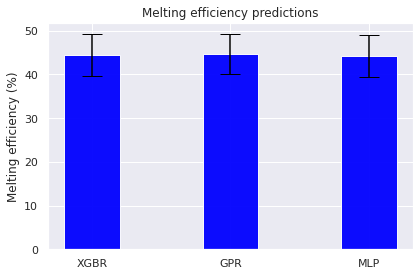

In [ ]:
# Build the plot
import seaborn as sns
sns.set()


fig, ax = plt.subplots()
#fig.set_size_inches((8,5))
width = [0.4,0.4, 0.4]

ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.95, ecolor='black', capsize=10, width=width, color='blue')
ax.set_ylabel('Melting efficiency (%)')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Melting efficiency predictions')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

## P-WAAM Ti64 prediction

In [ ]:
#Ti-6Al-4V data
data2 = pd.read_table('Ti64.txt') 
data2.describe()

,WD,WFS,TS,P
count,2.500000e+01,25.0,25.0,25.000000
mean,1.200000e+00,50.0,5.0,3373.381600
std,4.532467e-16,0.0,0.0,834.802047
min,1.200000e+00,50.0,5.0,2111.000000
25%,1.200000e+00,50.0,5.0,2863.880000
50%,1.200000e+00,50.0,5.0,3187.310000
75%,1.200000e+00,50.0,5.0,3684.420000
max,1.200000e+00,50.0,5.0,5454.590000


In [ ]:
scaler = StandardScaler()
X_64 = scaler.fit_transform(data2)

In [ ]:
R64XGB=np.array(xgbr.predict(X_64))
R64GP=np.array(GP.predict(X_64))
R64MLP=np.array(MLP.predict(X_64))


In [ ]:
R10_m=np.mean(R64GP*100)
R20_m=np.mean(R64XGB*100)
R30_m=np.mean(R64MLP*100)

In [ ]:
R10_sd=np.std(R64GP*100)
R20_sd=np.std(R64XGB*100)
R30_sd=np.std(R64MLP*100)

In [ ]:
# Create lists for the plot
labels = ['GPR', 'XGBR', 'MLP']
x_pos = np.arange(len(labels))
CTEs = [R10_m, R20_m, R30_m]
error = [R10_sd, R20_sd, R30_sd ]

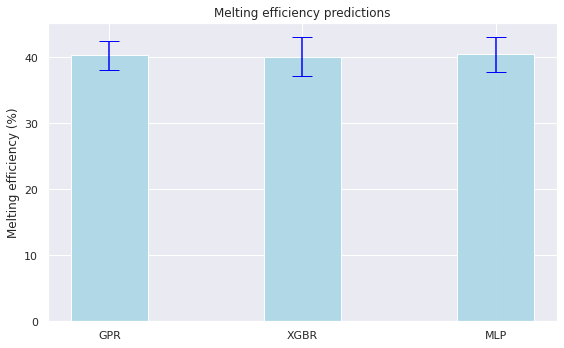

In [ ]:
# Build the plot
import seaborn as sns
sns.set()

fig, ax = plt.subplots()
fig.set_size_inches((8,5))
width = [0.4,0.4, 0.4]

ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.95, ecolor='blue', capsize=10, width=width, color='lightblue')
ax.set_ylabel('Melting efficiency (%)')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Melting efficiency predictions')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [ ]:
GP64=print(R10_m,R10_sd)

40.277243662516035 2.1550771219142586


In [ ]:
XGB64=print(R20_m,R20_sd)

40.072926 2.9172325


In [ ]:
ML64=print(R30_m,R30_sd)

40.44686746098448 2.6171246144061757


# Travel speed assessment

In [ ]:
#TS data
data3 = pd.read_table('TS2.txt') 
data3.describe()

,WD,WFS,TS,P
count,7.500000e+01,75.0,75.000000,75.0
mean,8.000000e-01,95.0,8.326533,2245.0
std,1.229469e-15,0.0,5.220140,0.0
min,8.000000e-01,95.0,1.660000,2245.0
25%,8.000000e-01,95.0,4.450000,2245.0
50%,8.000000e-01,95.0,6.670000,2245.0
75%,8.000000e-01,95.0,10.980000,2245.0
max,8.000000e-01,95.0,25.000000,2245.0


In [ ]:
scaler = StandardScaler()
X_TS = scaler.fit_transform(data3)

In [ ]:
TSXGB=np.array(xgbr.predict(X_TS))
TSGP=np.array(GP.predict(X_TS))
TSMLP=np.array(MLP.predict(X_TS))

In [ ]:
YTS=data3['TS'][:,None]

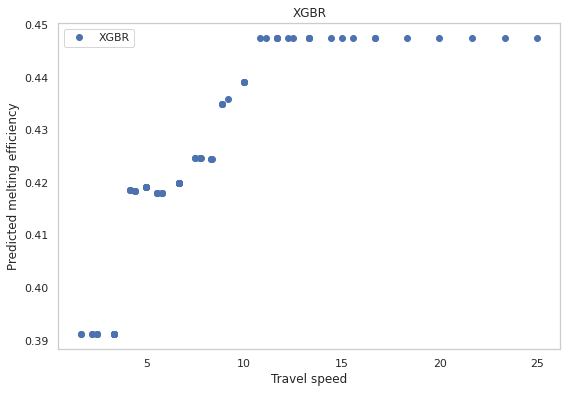

In [ ]:
#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(YTS, TSXGB, 'bo', label = 'XGBR')
plt.legend()
plt.ylabel('Predicted melting efficiency')
plt.xlabel('Travel speed')
plt.title("XGBR")
print()

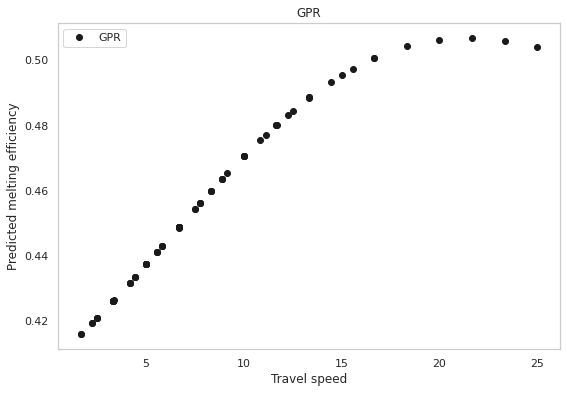

In [ ]:
#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(YTS, TSGP, 'ko', label = 'GPR')
plt.legend()
plt.ylabel('Predicted melting efficiency')
plt.xlabel('Travel speed')
plt.title("GPR")
print()

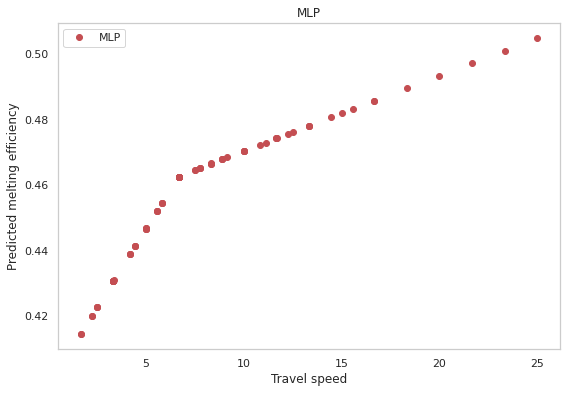

In [ ]:
#Plots
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False
fig = plt.figure()
fig.set_size_inches((9,6))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

plt.plot(YTS, TSMLP, 'ro', label = 'MLP')
plt.legend()
plt.ylabel('Predicted melting efficiency')
plt.xlabel('Travel speed')
plt.title("MLP")
print()

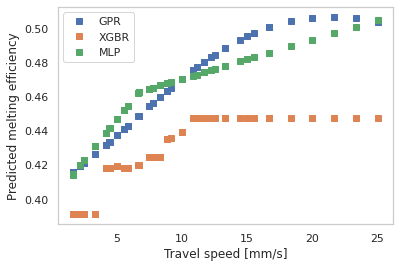

In [ ]:
sns.set_theme(style="whitegrid")
plt.rcParams["axes.grid"] = False

models = [ GP, xgbr, MLP]
labels = ['GPR', 'XGBR', 'MLP']

fig = plt.figure()
#fig.set_size_inches((9,6))

for mod, label in zip( models, labels): 
  y_pred = mod.predict(X_TS)
  plt.plot(YTS, y_pred, 's' ,label = label)

plt.ylabel('Predicted melting efficiency')
plt.xlabel('Travel speed [mm/s]')
plt.legend() 